In [1]:
import sys
sys.path.append(r'..\\')
from ioMicro import *

### Compute overall dapi

In [123]:
for set_ in ['_set1','_set2','_set3','_set4','_set5']:
    xys,fovs = get_xy(fld_ref = r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\H0_',set_ = set_)

    save_fld_master = r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023'
    segm_tag = 'H0_'
    segm_folder = save_fld_master+r'\Segmentation'
    final_fl = segm_folder+os.sep+'allCells--'+set_+'.zarr'
    um_per_pix = 0.1083333*4

    if not os.path.exists(final_fl):
        fov = fovs[0]
        fl_dapi = segm_folder+os.sep+fov+'--'+segm_tag+set_+'--dapi_segm.npz'
        im_segm = np.load(fl_dapi)['segm']
        shape = np.load(fl_dapi)['shape']
        sz,sx,sy = im_segm.shape
        pad=150
        xs_um_,ys_um_=(np.array(xys[:,::-1])*[1,-1]).T############################# scope dependent
        xs_pix = np.array(xs_um_)/um_per_pix
        xs_pix = np.array(xs_pix-np.min(xs_pix),dtype=int)+pad
        ys_pix = np.array(ys_um_)/um_per_pix
        ys_pix = np.array(ys_pix-np.min(ys_pix),dtype=int)+pad
        sx_big = np.max(xs_pix)+sx+pad+1
        sy_big = np.max(ys_pix)+sy+pad+1
        dim = [sz,sx_big,sy_big]
        im_big = np.zeros(dim,dtype = np.int64)
        for ifv,fov in enumerate(tqdm(fovs)):
            x_,y_ = xs_pix[ifv],ys_pix[ifv]
            fl_dapi = segm_folder+os.sep+fov+'--'+segm_tag+set_+'--dapi_segm.npz'
            im_segm = np.load(fl_dapi)['segm']
            im_segm_=stitch3d_new(im_segm,minsz = 200,maxsz = 1000,th_int=0.66,th_cover=0.8,th_max_subcell=0.66,nexpand = 5)
            ifovch = int(fov.split('_')[-1])#*10**5
            im_segm_pad = np.pad(im_segm_,pad_width=((0,0),(pad,pad),(pad,pad)),mode='constant',constant_values=0)
            #im_segm_[im_segm_>0]+=ifovch
            im_prev = im_big[...,x_-pad:x_+pad+sx,y_-pad:y_+pad+sy]
            im_segm_padf = get_connected_cells_neigh_fovs(im_prev,im_segm_pad,th_int = 0.5,reduce=10**7,ifov=ifovch)
            im_big[...,x_-pad:x_+pad+sx,y_-pad:y_+pad+sy]=im_segm_padf
        import zarr
        import dask.array as da
        zarr_array = zarr.array(im_big, chunks=(100, 100, 100))  # Define chunk size as per your requirement
        zarr.save(final_fl,zarr_array)
        np.savez(final_fl.replace('.zarr','.npz'),fovs = fovs,xys=xys,xs_pix=xs_pix,ys_pix=ys_pix,sxy_pixsz=[sx,sy,um_per_pix],shape=shape,shapesm=im_segm.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [09:18<00:00,  6.13s/it]


In [124]:
dask_array = da.from_zarr(segm_folder+os.sep+'allCells--'+set_+'.zarr')
napari.view_labels(dask_array);

### Combine the decoded spots from each group into a single file per fov

In [126]:
save_fld_master = r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023'

save_folders = [save_fld_master+r'\MERFISH_Analysis_group1',
               save_fld_master+r'\MERFISH_Analysis_group2',
               save_fld_master+r'\MERFISH_Analysis_group3',
               save_fld_master+r'\MERFISH_Analysis_group4',
               save_fld_master+r'\MERFISH_Analysis_group5',
               save_fld_master+r'\MERFISH_Analysis_group6']

scoresRef = save_fld_master+r'\scoresRef.npy'
drift_folder = save_fld_master+r'\Drift'

segm_tag = 'H0_'
segm_folder = save_fld_master+r'\Segmentation'
save_folder_all = save_fld_master+r'\Combined'


th=-1.5
ncols=2
tag_save='finaldecs_'
force=False
plt_val=False




In [136]:
def main_analysis(fov,scoresRef=scoresRef,force=force):
    if type(scoresRef) is str: scoresRef = np.load(scoresRef,allow_pickle=True)
    save_fl = save_folder_all+os.sep+os.sep+tag_save+fov.split('.')[0]+'--'+set_+'.npz'
    if not os.path.exists(save_fl) or force:

        if not os.path.exists(save_folder_all): os.makedirs(save_folder_all)


        ### Load point data ###############################
        all_gns_names = []
        XFF,genesFF = None,None
        for isave,save_folder in enumerate(save_folders):
            #save_folder = save_folders[0]
            dec = decoder_simple(save_folder,fov,set_)
            loaded = dec.load_decoded()
            if not loaded:
                print(save_fl, "Did not have a valid decoded file.")
                #return None
            dec.gns_names = np.array([gn+'_'+str(isave) if gn in all_gns_names else gn for gn in dec.gns_names])
            all_gns_names = np.unique(np.concatenate([all_gns_names,dec.gns_names]))

            ### Threshold point data ###############################
            dec.ncols=ncols
            get_score_withRef(dec,scoresRef,plt_val=plt_val,gene=None,iSs = None)
            dec.th=th
            if plt_val:
                plot_statistics(dec)
            #print(dec.gns_ordered)



            keepf =  dec.scoreA>dec.th ### keep good score
            icodesf = dec.icodesN[keepf]
            XHfpr = dec.XH_pruned[keepf]

            ### Reorganize data  ###############################
            XHf = np.mean(XHfpr,axis=1)
            XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
            #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
            XF[:,-1] = dec.scoreA[keepf]
            XF[:,-2] = np.where(keepf)[0]
            mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
            XF[:,-3]=mnD
            mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
            XF[:,-4]=mnH
            genesf = dec.gns_names[icodesf]

            ### Load and apply drift correction
            def get_drft_dic(fl_all_drift):
                drft,flds,fov_,fl_ref= np.load(fl_all_drift,allow_pickle=True)
                return {'--'.join(fld.split(os.sep)[-2:]):drft_[0] for fld,drft_ in zip(flds,drft)}
            fl_all_drift = drift_folder+os.sep+'driftNew_'+fov+'--'+set_+'.pkl'
            drft_dic_all = get_drft_dic(fl_all_drift)
            fl_all_drift = save_folder+os.sep+'driftNew_'+fov+'--'+set_+'.pkl'
            drft_dic_group = get_drft_dic(fl_all_drift)
            key_segm = [key for key in drft_dic_all if segm_tag in key][0]
            key_align = np.intersect1d(list(drft_dic_all.keys()),list(drft_dic_group.keys()))[0]
            th1_to_h0 = drft_dic_all[key_segm]-drft_dic_all[key_align]
            th1_gr = drft_dic_group[key_align]
            tzxyf = th1_gr+th1_to_h0
            XF[:,:3]=XF[:,:3]-tzxyf #### do not add here
            
            
            ### Load dapi
            if True:
                dec.fl_dapi = segm_folder+os.sep+fov+'--'+segm_tag+set_+'--dapi_segm.npz'
                dic = np.load(dec.fl_dapi)
                im_segm = dic['segm']
                dec.shape = dic['shape']
                dec.im_segm_=stitch3d_new(im_segm,minsz = 200,maxsz = 1000,th_int=0.66,th_cover=0.8,th_max_subcell=0.66,nexpand = 5)
                dec.shapesm = np.array(dec.im_segm_.shape)
            else:
                dec.fl_dapi = segm_folder+os.sep+'allCells--'+set_+'.zarr'
                full_im_segm = da.from_zarr(dec.fl_dapi)
                dic_info = np.load(dec.fl_dapi.replace('.zarr','.npz'))
                #fovs = fovs,xys=xys,xs_pix=xs_pix,ys_pix=ys_pix,sxy_pixsz=[sx,sy,um_per_pix],shape=shape,shapesm=im_segm.shape)
                xs_pix,ys_pix=dic_info['xs_pix'],dic_info['ys_pix']
                fovs,dec.shape=dic_info['fovs'],dic_info['shape']
                sx,sy,um_per_pix = dic_info['sxy_pixsz']
                ifv_ = list(fovs).index(fov)
                x_,y_ = xs_pix[ifv_],ys_pix[ifv_]
                dec.shapesm = np.array([len(full_im_segm),sx,sy])
                ### incomplete here
                np.min(XF[:,:3],axis=0)
                
                tz,tx,ty = np.round(tzxyf/dec.shape*dec.shapesm).astype(int)
                
                dec.im_segm_= np.array(full_im_segm[...,x_+tx:x_+sx+tx,y_+ty:y_+sy+ty])
            
            if XFF is None:
                XFF,genesFF = XF,genesf
            else:
                XFF,genesFF = np.concatenate([XFF,XF]),np.concatenate([genesFF,genesf])



        def get_cell_id(dec,Xh):
            if not hasattr(dec,'im_segm_'): 
                good = np.ones(len(Xh),dtype=bool)
                cells_ = np.zeros(len(Xh),dtype=int)
                return cells_,good
            im_segm = dec.im_segm_
            dec.shapesm = dec.im_segm_.shape
            Xcms = Xh[:,:3]
            Xred = np.round((Xcms/dec.shape)*dec.shapesm).astype(int)
            good = ~np.any((Xred>=dec.shapesm)|(Xred<0),axis=-1)
            Xred = Xred[good]
            if True:
                v = napari.view_points(Xred,opacity=0.1,size=1.5)
                v.add_labels(im_segm)
            return im_segm[tuple(Xred.T)],good

        XF,genesf = XFF,genesFF  
        cell_id,good = get_cell_id(dec,XF)
        XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
        genesf_ = genesf[good]
        iset = int(dec.set_.split('_set')[-1])
        ifov = int(dec.fov.split('_')[-1].split('.')[0])
        isets = np.array([iset]*len(cell_id))[:,np.newaxis]
        ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
        cell_id = cell_id[:,np.newaxis]
        XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)

        get_xyfov(dec)
        XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1]]
        XF_[:,-2:]=dec.xfov,dec.yfov
        header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                  'index_from_XH_pruned','score','cell_id','ifov','iset','xfov','yfov']

        if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//4)
        icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
        #icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
        cellinfo = cms[:,[0,0,0,1,2,0,0]]
        cellinfo[:,0]=icells
        cellinfo[:,1]=vols
        cellinfo[:,-2:]=dec.xfov,dec.yfov
        header_cells = ['cell_id','volm','zc','xc','yc','xfov','yfov']
        if True:
            np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
        print("Finished",fov)
        

In [137]:
set_='_set1'
fovs = [os.path.basename(fl).split('--')[0] for fl in glob.glob(segm_folder+os.sep+'*'+set_+'*.npz')]
print(len(fovs))
fov = fovs[10]
main_analysis(fov,force=True)

68
Loaded decoded: -1.3076536655426025
Loaded decoded: -1.5833332538604736
Loaded decoded: -2.0887928009033203
Loaded decoded: -1.9264092445373535
Loaded decoded: -2.5978009700775146
Loaded decoded: -2.229644775390625
Finished Conv_zscan__09


In [131]:
set_ = '_set1'
fovs = [os.path.basename(fl).split('--')[0] for fl in glob.glob(segm_folder+os.sep+'*'+set_+'*.npz')]
fov = fovs[2]
main_analysis(fov)

In [9]:
for set_ in ['_set1','_set5','_set3','_set4','_set2']:
    fovs = [os.path.basename(fl).split('--')[0] for fl in glob.glob(segm_folder+os.sep+'*'+set_+'*.npz')]
    print("Number of fovs for set:",set_,len(fovs))
    for fov in fovs:
        try:
            main_analysis(fov)
        except:
            print("Failed",fov)

Number of fovs for set: _set1 67
Loaded decoded: -0.8801188468933105
Failed Conv_zscan__02
Loaded decoded: -0.03558659553527832
Loaded decoded: -0.08001232147216797
Loaded decoded: -0.03200483322143555
Loaded decoded: -0.03340792655944824
Loaded decoded: -0.0836493968963623
Loaded decoded: -0.08653783798217773
Finished Conv_zscan__29
Loaded decoded: -0.03999948501586914
Loaded decoded: -0.04000687599182129
Loaded decoded: -0.07135868072509766
Loaded decoded: -0.04800701141357422
Loaded decoded: -0.04001641273498535
Loaded decoded: -0.0640101432800293
Finished Conv_zscan__33
Loaded decoded: -0.12001872062683105
Loaded decoded: -0.1280193328857422
Loaded decoded: -0.11763358116149902
Loaded decoded: -0.16898536682128906
Loaded decoded: -0.170029878616333
Loaded decoded: -0.12476801872253418
Finished Conv_zscan__35
Loaded decoded: -0.12546896934509277
Loaded decoded: -0.1280193328857422
Loaded decoded: -0.1200559139251709
Loaded decoded: -0.12809062004089355
Loaded decoded: -0.09654951095

In [85]:
save_fld_master = r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023'
save_fls = glob.glob(save_fld_master+r"\Combined\finaldecs_*")
#print(save_fl)
len(save_fls)

288

In [86]:
set_ = '_set3'
for set_ in ['_set3','_set4','_set5']:
    save_fls_ = [fl for fl in save_fls if (set_ in fl)]# in fl if '035' in fl][0]
    cell_df,df=None,None
    for save_fl in tqdm(np.sort(save_fls_)[:]):
        ### load info
        dic = np.load(save_fl)
        XF = dic['XF']
        header = list(dic['header'])
        genes_decoded = dic['genes']
        cells = dic['cellinfo'][1:]
        header_cells = dic['header_cells']
        ### Rethrehold based on score
        iscore = list(header).index('score')
        scoreA = XF[:,iscore]
        keep = scoreA>-0.75
        ugns,gns_i = np.unique(genes_decoded[keep],return_inverse=True)

        icell = header.index('cell_id')
        icells = XF[keep,icell].astype(int)

        icellsf = cells[:,0].astype(int)
        if len(icellsf):
            mcell = np.max(icellsf)+1
            gn_cell,gn_cell_cts = np.unique(mcell*gns_i+icells,return_counts=True)
            len(gn_cell)
            igns_ = gn_cell//mcell
            icells_ = gn_cell%mcell
            Mcts = np.zeros([mcell,len(ugns)])
            Mcts[icells_,igns_]=gn_cell_cts

            Mcts[icellsf].shape
            if len(XF):
                ifov,iset = int(XF[0,header.index('ifov')]),int(XF[0,header.index('iset')])
                icellsnm = [icell+10**5*ifov for icell in icellsf]#icellsnm = [icell+10**5*ifov+10**9*iset for icell in icellsf]

                dfT = pd.DataFrame(Mcts[icellsf],columns=ugns,index=icellsnm)


                df = dfT if df is None else pd.concat([df,dfT])
                cell_dfT = pd.DataFrame(cells,columns=header_cells,index=icellsnm)
                cell_df = cell_dfT if cell_df is None else pd.concat([cell_df,cell_dfT])
        else:
            print("No cells in:",save_fl)

    tag = os.path.basename(save_fld_master)
    save_folderf = save_fld_master+r'\final_spots'
    if not os.path.exists(save_folderf): os.makedirs(save_folderf)
    fl_df = save_folderf+os.sep+tag+'--'+set_+r'_df.pkl'
    df.to_pickle(fl_df)
    fl_celldf = save_folderf+os.sep+tag+'--'+set_+r'_celldf.pkl'
    cell_df.to_pickle(fl_celldf)

    print(fl_celldf)
    print(fl_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [02:26<00:00,  2.04s/it]


\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\final_spots\HttHuman_Snonia__06_12_2023--_set3_celldf.pkl
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\final_spots\HttHuman_Snonia__06_12_2023--_set3_df.pkl


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [01:25<00:00,  1.48s/it]


\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\final_spots\HttHuman_Snonia__06_12_2023--_set4_celldf.pkl
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\final_spots\HttHuman_Snonia__06_12_2023--_set4_df.pkl


  0%|                                                                                           | 0/91 [00:00<?, ?it/s]

No cells in: \\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\Combined\finaldecs_Conv_zscan__00--_set5.npz


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 89/91 [03:09<00:03,  1.79s/it]

No cells in: \\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\Combined\finaldecs_Conv_zscan__89--_set5.npz


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [03:09<00:00,  2.08s/it]


\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\final_spots\HttHuman_Snonia__06_12_2023--_set5_celldf.pkl
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\final_spots\HttHuman_Snonia__06_12_2023--_set5_df.pkl


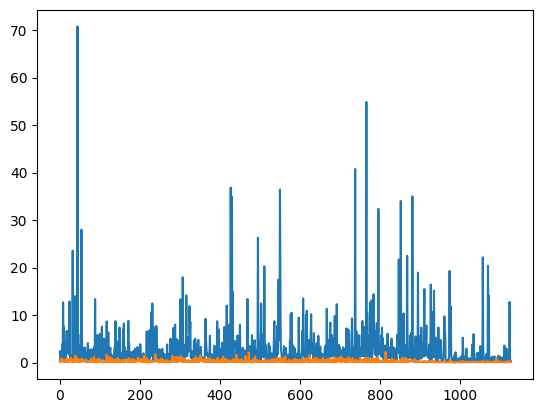

In [30]:
genes = np.array(list(df.keys()))
bad = np.array(['blank' in e for e in list(df.keys())])
plt.plot(np.nanmean(df[genes[~bad]],axis=0))
plt.plot(np.nanmean(df[genes[bad]],axis=0))


In [36]:
tag = os.path.basename(save_fld_master)
save_folderf = save_fld_master+r'\final_spots'
if not os.path.exists(save_folderf): os.makedirs(save_folderf)
fl_df = save_folderf+os.sep+tag+'--'+set_+r'_df.pkl'
df.to_pickle(fl_df)
fl_celldf = save_folderf+os.sep+tag+'--'+set_+r'_celldf.pkl'
cell_df.to_pickle(fl_celldf)

print(fl_celldf)
print(fl_df)

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\final_spots\HttHuman_Snonia__06_12_2023--_set1_celldf.pkl
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\final_spots\HttHuman_Snonia__06_12_2023--_set1_df.pkl


In [41]:
          
def plot_gene_mosaic_cells(df,cell_df,gene,plt_fov=False,pixel_size = 0.10833*4,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20):
    ###scope4
    #xcells = cell_df['xc']*pixel_size-cell_df['xfov']
    #ycells = cell_df['yc']*pixel_size-cell_df['yfov']
    ###scope3
    xcells = cell_df['xc']*pixel_size+cell_df['yfov']
    ycells = cell_df['yc']*pixel_size-cell_df['xfov']
    Xcells = np.array([xcells*flipx,ycells*flipy][::transpose]).T
    
    cts = np.array(df[gene])#Ptbp1_smFISH
    
    cts[np.isnan(cts)]=0
    ncts = np.clip(cts/nmax,0,1)
    size = sz_min+ncts*(sz_max-sz_min)
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)
    import napari
    good_cells = slice(None)
    XC = -Xcells[good_cells,::-1]
    viewer = napari.view_points(XC,size=size,face_color=cols[good_cells],name=gene)
    if plt_fov:
        ifovs = np.array(list(df.index),dtype=int)//10**5
        ifov_unk = np.unique(ifovs)
        Xfov = np.array([np.mean(XC[ifovs==ifov],axis=0)for ifov in ifov_unk])
        features =  {'fov':ifov_unk}
        text = {
            'string': '{fov:.1f}',
            'size': 20,
            'color': 'gray',
            'translation': np.array([0, 0]),
        }
        viewer.add_points(Xfov,text=text,features=features,edge_width=0)

In [69]:
plot_gene_mosaic_cells(df,cell_df,'KIF1A',plt_fov=False,pixel_size = 0.10833*4,transpose=1,nmax=30)

### Check different bits in different libraries

In [71]:
lib_fls = glob.glob(r'C:\Scripts\NMERFISH\codebooks\codebook_Sonia2colorP*_group*_blank.csv')
dic_lib={}
for fl in lib_fls:
    gns_ = list(pd.read_csv(fl)['name'])
    for gn in gns_:
        if 'blank' not in gn:
            dic_lib[gn]=os.path.basename(fl).split('color')[-1]

In [87]:
import scanpy as sc

In [113]:
set_='_set1'
tag = os.path.basename(save_fld_master)
save_folderf = save_fld_master+r'\final_spots'
if not os.path.exists(save_folderf): os.makedirs(save_folderf)
fl_df = save_folderf+os.sep+tag+'--'+set_+r'_df.pkl'
fl_celldf = save_folderf+os.sep+tag+'--'+set_+r'_celldf.pkl'
df = pd.read_pickle(fl_df)
cell_df=pd.read_pickle(fl_celldf)

In [114]:
genes = np.array(list(df.keys()))
bad = np.array(['blank' in e for e in list(df.keys())])
genes = genes[~bad]
means = np.nanmean(df[genes],axis=0)
gns_top = genes[np.argsort(means)[::-1]][:100]
[(gn,dic_lib[gn]) for gn in gns_top]

[('APP', 'P2_group1_blank.csv'),
 ('SPARCL1', 'P3_group1_blank.csv'),
 ('SLC17A7', 'P2_group1_blank.csv'),
 ('KIF1A', 'P3_group1_blank.csv'),
 ('NEFL', 'P1_group2_blank.csv'),
 ('YWHAG', 'P3_group2_blank.csv'),
 ('KIF5A', 'P3_group2_blank.csv'),
 ('UBC', 'P3_group2_blank.csv'),
 ('SYT1', 'P3_group1_blank.csv'),
 ('ATP1A2', 'P1_group2_blank.csv'),
 ('MAP2', 'P3_group1_blank.csv'),
 ('ANK2', 'P2_group1_blank.csv'),
 ('VSNL1', 'P2_group1_blank.csv'),
 ('SLC1A2', 'P2_group2_blank.csv'),
 ('TUBB4A', 'P2_group1_blank.csv'),
 ('SPTAN1', 'P2_group2_blank.csv'),
 ('MIAT', 'P1_group2_blank.csv'),
 ('CHN1', 'P2_group2_blank.csv'),
 ('CLU', 'P3_group2_blank.csv'),
 ('GFAP', 'P3_group1_blank.csv'),
 ('NEFM', 'P1_group1_blank.csv'),
 ('NDRG4', 'P3_group2_blank.csv'),
 ('RTN1', 'P3_group2_blank.csv'),
 ('MEG3', 'P3_group2_blank.csv'),
 ('TSPAN7', 'P3_group2_blank.csv'),
 ('KIF5C', 'P3_group1_blank.csv'),
 ('STMN3', 'P3_group1_blank.csv'),
 ('GPRC5B', 'P3_group1_blank.csv'),
 ('SPTBN1', 'P2_group2_bla

### check drfit

In [144]:
drift_fl = r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\MERFISH_Analysis_group4\driftNew_Conv_zscan__19--_set1.pkl'
def check_drift(drift_fl):
    drft,flds,fov_,fl_ref = np.load(drift_fl,allow_pickle=True)
    print(flds)
    from dask import array as da
    ims = da.concatenate([da.roll(read_im(fld+os.sep+fov_)[-1],np.round(drft_[0]).astype(int),axis=[0,1,2])[np.newaxis] for fld,drft_ in zip(flds,drft)])
    import napari
    napari.view_image(ims)

In [152]:
check_drift(drift_fl.replace('MERFISH_Analysis_group4','MERFISH_Analysis_group4'))

['\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H37_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H38_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H39_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H40_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H41_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H42_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H43_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H44_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H45_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H46_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H47_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H48_MER2col__set1']


Signature: load_segmentation(dec)
Docstring: <no docstring>
Source:   
def get_scores(dec,plt_val=True,gene='Ptbp1'):
    H = np.median(dec.XH_pruned[...,4],axis=1)
    Hd = np.std(dec.XH_pruned[...,4],axis=1)/H
    D = dec.XH_pruned[...,:3]-np.mean(dec.XH_pruned[...,:3],axis=1)[:,np.newaxis]
    D = np.mean(np.linalg.norm(D,axis=-1),axis=-1)
    score = np.array([H,-D])
    scoreA = np.argsort(np.argsort(score,axis=-1),axis=-1)+1
    scoreA = np.sum(np.log(scoreA)-np.log(len(D)),axis=0)
    dec.scoreA = scoreA
    if plt_val:
        bad_igns = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn.lower()]
        good_igns = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' not in gn.lower()]
        is_good_gn = np.in1d(dec.icodesN,good_igns)
        
        plt.figure()
        plt.hist(scoreA[is_good_gn],density=True,bins=100,alpha=0.5,label='all genes')
        if gene is not None:
            is_gn = dec.icodesN==(list(dec.gns_names).index(gene))
            plt.his

In [153]:
check_drift(drift_fl.replace('MERFISH_Analysis_group4','Drift'))

['\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H1_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H13_MER2col__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H25_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H37_MER2col__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H49_MER2col__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H61_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H0__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A1_Htt_Nup98__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A2_LamA_B__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A3_SC35_gH2AX__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A4_gH2AX_PSMB5__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\P1__Gad1_Nrgn_Aqp4__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snon

In [147]:
['\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H1_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H13_MER2col__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H25_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H37_MER2col__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H49_MER2col__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H61_MER2col__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H0__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A1_Htt_Nup98__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A2_LamA_B__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A3_SC35_gH2AX__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A4_gH2AX_PSMB5__set1', '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\P1__Gad1_Nrgn_Aqp4__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\P2__Gad1_Nrgn_Aqp4_B__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\P3__Htt_CAG_B_polyA__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\P4__Htt_B_B_B__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\P5__SST_OPALIN__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\P6__PTBP1_OLIG1__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\P7__LMNB2_LMNA_NUP98__set1', '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\P8__MBP_TH_GFAP__set1'][3]

'\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H37_MER2col__set1'

In [111]:
37-48 - bad?

36

In [133]:
plot_gene_mosaic_cells(df,cell_df,'SPTBN1',plt_fov=True,pixel_size = 0.10833*4,transpose=1,nmax=30)

In [115]:
P1G1,P1G2, P2G1,P3G1-good

In [123]:
dic_lib['NEFL']

'P1_group2_blank.csv'

In [ ]:
'CIRBP','APOE'

In [ ]:
fls = glob.glob(r'C:\Scripts\NMERFISH\codebooks\codebook_Sonia2colorP*_group*_blank.csv')

gns = [[gn for gn in list(pd.read_csv(fl)['name']) if 'blank' not in gn] for fl in fls]
[[len(np.intersect1d(gn1,gn2))for gn1 in gns] for gn2 in gns]

[[188, 0, 0, 0, 0, 0],
 [0, 187, 0, 0, 0, 0],
 [0, 0, 187, 0, 0, 0],
 [0, 0, 0, 188, 0, 0],
 [0, 0, 0, 0, 189, 0],
 [0, 0, 0, 0, 0, 189]]

In [106]:
print(list(np.unique(all_gns_names)))

['AAAS', 'AARD', 'ABCB1', 'ABI3BP', 'ACAT2', 'ACTA1', 'ACTA2', 'ACTB', 'ACTC', 'ACTG1', 'ACTL6B', 'ACTN1', 'ADAMTS17', 'ADAMTS2', 'ADAMTS9-AS2', 'ADAMTSL1', 'ADAMTSL3', 'ADARB2', 'ADGRG1', 'ADGRV1', 'AEBP1', 'AGFG1', 'AGPAT3', 'AGPAT5', 'AHCTF1', 'AHI1', 'AHNAK2', 'AIM2', 'AKAP6', 'AKIRIN1', 'AKT3', 'ALDH1A1', 'ALDH1L1', 'ALOX5', 'ALOX5AP', 'AMBP', 'ANK2', 'ANK3', 'ANKRD17', 'ANLN', 'ANXA11', 'ANXA2', 'ANXA4', 'AP2B1', 'APAF1', 'APBB1IP', 'APLP2', 'APOC1', 'APOD', 'APOE', 'APOO', 'APP', 'AQP1', 'AQP4', 'ARHGEF11', 'ARL17B', 'ARPP21', 'ASGR2', 'ASIC2', 'ASIC4', 'ATOH8', 'ATP11B', 'ATP13A4', 'ATP1A2', 'ATP1B1', 'ATP1B3', 'ATP2A3', 'ATP5E', 'ATP5G2', 'ATP6AP2', 'ATP6V1F', 'ATP7B', 'ATP8A2', 'ATP8B4', 'ATPIF1', 'B2M', 'BAD', 'BANF1', 'BARX1', 'BAX', 'BCAS1', 'BCHE', 'BCL-X', 'BCL2', 'BEAN1', 'BEX1', 'BEX2', 'BICD2', 'BMP2', 'BRAP', 'BRCA1', 'BRCA2', 'BRIP1', 'BSPRY', 'C1ORF132', 'C1ORF172', 'C1QB', 'C1QC', 'C1QL3', 'C2CD5', 'C4ORF26', 'C8orf34', 'C9ORF142', 'C9ORF72', 'CA1', 'CA10', 'CA2',

In [67]:
segm_tag = 'H0_'
segm_folder = r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\Segmentation'


(166986, 11)

In [ ]:
cell_id,good = get_cell_id(dec,XF)

In [80]:
Xcms = XF[:,:3]-tzxyf
Xred = np.round((Xcms/dec.shape)*dec.shapesm).astype(int)
import napari
v = napari.Viewer()
v.add_labels(dec.im_segm_)
v.add_points(Xred,size=0.5)

<Points layer 'Xred' at 0x25d07460ca0>

In [ ]:
Conv_zscan__324--H0__set1--dapi_segm.npz

In [ ]:
def save_final_decoding(save_folder,fov,set_,scoresRef,th=-1.5,ncols=3,
                        tag_save = 'finaldecs_',
                        plt_val=False,apply_flat=True,
                        tags_smFISH=['Aldh','Sox11'],
                        genes_smFISH=[['Igfbpl1','Aldh1l1','Ptbp1'],['Sox11','Sox2','Dcx']],Hths=None,force=False,try_mode=True):
    """
    This loads the decoded points renormalizes them and picks the most confident points
    """
    if type(scoresRef) is str: scoresRef = np.load(scoresRef,allow_pickle=True)
    dec = decoder_simple(save_folder,fov,set_)
    save_fl = dec.save_folder+os.sep+os.sep+tag_save+dec.fov.split('.')[0]+'--'+dec.set_+'.npz'
    if not os.path.exists(save_fl) or force:
        #print(dec.fov,dec.set_)
        def main_subf(dec,save_fl,save_folder,fov,set_,scoresRef,th,ncols,plt_val,apply_flat,tags_smFISH,genes_smFISH,Hths,force):
            nsegm = load_segmentation(dec)
            loaded = dec.load_decoded()
            if not loaded:
                print(save_fl, "Did not have a valid decoded file.")
                return None
            if apply_flat:
                apply_flat_field(dec)
            apply_fine_drift(dec,plt_val=plt_val)
            
            #for i in range(3):
            #    apply_brightness_correction(dec)
            #get_scores(dec,plt_val=plt_val)
            dec.ncols=ncols
            get_score_withRef(dec,scoresRef,plt_val=plt_val,gene=None,iSs = None)
            dec.th=th
            #plot_1gene(dec,gene='Gad1',viewer = None)
            if plt_val:
                viewer = plot_multigenes(dec,genes=['Adcy1','Slc1a2','Psap'],colors=['r','g','b','m','c','y','w'],viewer = None,
                                         smin=1,smax=2.5,drift=dec.drift[0],
                                        resc = dec.shape/dec.im_segm_.shape)
                viewer.add_labels(dec.im_segm_);
            if plt_val:
                plot_statistics(dec)
            #print(dec.gns_ordered)

            keepf =  dec.scoreA>dec.th ### keep good score
            icodesf = dec.icodesN[keepf]
            XHfpr = dec.XH_pruned[keepf]
            XHf = np.mean(XHfpr,axis=1)
            if Hths is None:
                ICol = XHfpr[:,:,-2].astype(int)
                Hths = [np.percentile(XHfpr[ICol==icol][:,-3],15) for icol in np.unique(ICol)]
            
            XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
            #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
            XF[:,-1] = dec.scoreA[keepf]
            XF[:,-2] = np.where(keepf)[0]
            mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
            XF[:,-3]=mnD
            mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
            XF[:,-4]=mnH
            genesf = dec.gns_names[icodesf]
            
            ### deal with smFISH
            for tag_smFISH,gns_smFISH in zip(tags_smFISH,genes_smFISH):
                dec.get_XH_tag(tag=tag_smFISH)#dec.get_XH_tag(tag='Aldh1')
                if len(dec.Xh.shape)>1:
                    if len(dec.Xh)>0:
                        if apply_flat:
                            Xh = norm_brightness(dec,dec.Xh)
                        else:
                            Xh = dec.Xh

                        tags = [gn+'_smFISH' for gn in gns_smFISH]#['Igfbp_smFISH','Aldh1l1_smFISH','Ptbp1_smFISH']

                        for icol,tag_gn in enumerate(tags):
                            Xh_ = Xh[Xh[:,-2]==icol]
                            Xh_=Xh_[Xh_[:,-3]>Hths[icol]]
                            Xh_=Xh_[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
                            Xh_[:,-1]=0
                            Xh_[:,-2]=-1
                            Xh_[:,-3]=0
                            Xh_[:,-4]=0
                            XF = np.concatenate([XF,Xh_])
                            genesf = np.concatenate([genesf,[tag_gn]*len(Xh_)])

            cell_id,good = get_cell_id(dec,XF)
            XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
            genesf_ = genesf[good]
            iset = int(dec.set_.split('_set')[-1])
            ifov = int(dec.fov.split('_')[-1].split('.')[0])
            isets = np.array([iset]*len(cell_id))[:,np.newaxis]
            ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
            cell_id = cell_id[:,np.newaxis]
            XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)

            get_xyfov(dec)
            XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1]]
            XF_[:,-2:]=dec.xfov,dec.yfov
            header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                      'index_from_XH_pruned','score','cell_id','ifov','iset','xfov','yfov']
            
            if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//4)
            icells,vols = np.unique(dec.im_segm_,return_counts=True)
            cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
            #icells,vols = np.unique(dec.im_segm_,return_counts=True)
            cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
            cellinfo = cms[:,[0,0,0,1,2,0,0]]
            cellinfo[:,0]=icells
            cellinfo[:,1]=vols
            cellinfo[:,-2:]=dec.xfov,dec.yfov
            header_cells = ['cell_id','volm','zc','xc','yc','xfov','yfov']

            np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
        if try_mode:
            try:
                main_subf(dec,save_fl,save_folder,fov,set_,scoresRef,th,ncols,plt_val,apply_flat,tags_smFISH,genes_smFISH,Hths,force)
            except:
                print("Failed",dec.fov,dec.set_)
        else:
            main_subf(dec,save_fl,save_folder,fov,set_,scoresRef,th,ncols,plt_val,apply_flat,tags_smFISH,genes_smFISH,Hths,force)
    

In [84]:
get_xyfov(dec)

In [7]:
flds

['\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate1\\H1_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate1\\H13_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate2\\H1_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate2\\H13_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate3\\H1_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate3\\H13_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\H0__set1']